In [30]:
import os
import json
import shutil
import pickle
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
from torch.amp import autocast
import random
import traceback
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from transformers import AutoTokenizer, CLIPProcessor, CLIPConfig, CLIPModel, CLIPTokenizer, ViTModel
import gc



# Base Directory
BASE_PATH = r'C:\Users\csury\Documents\DL\PROJECT'

## DATA PREPROCESSING

### CONFIGURATION

In [31]:
# Configuration class for VQA model
class VQAConfig:
   def __init__(self):
       self.root = os.path.normpath(r'C:\Users\csury\Documents\DL\PROJECT')
       self.data_dir = os.path.normpath(os.path.join(self.root, 'DATA'))
       self.model_dir = os.path.normpath(os.path.join(self.root, 'models'))

       # Cache paths
       self.cache_dir = os.path.normpath(os.path.join(self.data_dir, 'cache'))
       self.proc_cache = os.path.normpath(os.path.join(self.cache_dir, 'processed_data.pkl'))
       self.loader_cache = os.path.normpath(os.path.join(self.cache_dir, 'dataloaders.pkl'))
       self.subset_cache = os.path.normpath(os.path.join(self.cache_dir, 'subsets'))

       # Data paths
       self.img_dir = os.path.normpath(os.path.join(self.data_dir, 'train2014'))
       self.q_path = os.path.normpath(os.path.join(self.data_dir, 'v2_OpenEnded_mscoco_train2014_questions.json'))
       self.ann_path = os.path.normpath(os.path.join(self.data_dir, 'v2_mscoco_train2014_annotations.json'))

       # Dataset parameters
       self.total_size = 50000  
       self.splits = {
           'train': 0.7,
           'val': 0.15,
           'test': 0.15
       }

       self.q_quotas = {
           'yes/no': int(self.total_size * 0.4),
           'color': int(self.total_size * 0.3),
           'count': int(self.total_size * 0.3)
       }

       # Model parameters
       self.vit_size = 224
       self.clip_size = 224
       self.vit_patch_size = 16

       self._create_directories()

   def _create_directories(self):
       dirs = [
           self.data_dir,
           self.model_dir,
           self.cache_dir,
           self.subset_cache,
           self.img_dir
       ]
       for dir in dirs:
           os.makedirs(dir, exist_ok=True)

   def verify_paths(self):
       print("\nChecking directory structure")
       paths = {
           'Project directory': self.root,
           'Data directory': self.data_dir,
           'Models directory': self.model_dir,
           'Image directory': self.img_dir,
           'Questions file': self.q_path,
           'Annotations file': self.ann_path
       }

       missing = []
       for name, path in paths.items():
           if os.path.exists(path):
               print(f"Found: {name} at {path}")
           else:
               print(f"Missing: {name} at {path}")
               missing.append(name)

       if missing:
           print("\nWarning: Following paths are missing:")
           for path in missing:
               print(f"- {path}")

   def check_cache(self):
       cache_files = {
           'processed_data': self.proc_cache,
           'dataloaders': self.loader_cache,
           'train_subset': os.path.join(self.subset_cache, 'train.pkl'),
           'val_subset': os.path.join(self.subset_cache, 'val.pkl'),
           'test_subset': os.path.join(self.subset_cache, 'test.pkl')
       }

       print("\nCache Status:")
       for name, path in cache_files.items():
           exists = os.path.exists(path)
           if exists:
               size_mb = os.path.getsize(path) / (1024 * 1024)
               print(f"{name}: Available ({size_mb:.1f} MB)")
           else:
               print(f"{name}: Not found")




config = VQAConfig()
print("Initial verification:")
config.verify_paths()
config.check_cache()

Initial verification:

Checking directory structure
Found: Project directory at C:\Users\csury\Documents\DL\PROJECT
Found: Data directory at C:\Users\csury\Documents\DL\PROJECT\DATA
Found: Models directory at C:\Users\csury\Documents\DL\PROJECT\models
Found: Image directory at C:\Users\csury\Documents\DL\PROJECT\DATA\train2014
Found: Questions file at C:\Users\csury\Documents\DL\PROJECT\DATA\v2_OpenEnded_mscoco_train2014_questions.json
Found: Annotations file at C:\Users\csury\Documents\DL\PROJECT\DATA\v2_mscoco_train2014_annotations.json

Cache Status:
processed_data: Available (293.3 MB)
dataloaders: Not found
train_subset: Available (63.1 MB)
val_subset: Available (13.5 MB)
test_subset: Available (13.5 MB)


### PROCESSORS

In [32]:
class QuestionProcessor:
   def __init__(self):
       self.tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
       self.max_length = 77

       # Question categories
       self.yes_no_patterns = ['is ', 'are ', 'does ', 'do ', 'was ', 'were ', 'has ', 'have ']
       self.color_patterns = ['color', 'colour', 'what color is', 'what colour is']
       self.count_patterns = ['how many', 'number of', 'count', 'total number']


   # Classification of question 
   def classify_question(self, question_text):
       q = question_text.lower().strip()

       if any(q.startswith(pattern) for pattern in self.yes_no_patterns):
           return 'yes/no'
       if any(pattern in q for pattern in self.color_patterns):
           return 'color'
       if any(pattern in q for pattern in self.count_patterns):
           return 'count'
       return None

   def __call__(self, question):
       return self.tokenizer(
           question,
           padding='max_length',
           truncation=True,
           max_length=self.max_length,
           return_tensors='pt'
       )

# Building answer vocabulary from annotations
class AnswerProcessor:
   def __init__(self, max_answers=3129):
       self.max_answers = max_answers
       self.ans2idx = {}  
       self.idx2ans = {}  
       self.ans_freq = {}  

   
   
   def build_vocabulary(self, annotations):
       for ann in annotations:
           for answer in ann['answers']:
               ans = answer['answer']
               self.ans_freq[ans] = self.ans_freq.get(ans, 0) + 1

       top_answers = sorted(self.ans_freq.items(), key=lambda x: x[1], reverse=True)[:self.max_answers]

       for idx, (answer, _) in enumerate(top_answers):
           self.ans2idx[answer] = idx
           self.idx2ans[idx] = answer



   # Gives most frequent answer and confidence score
   def process_answers(self, answers):
       ans_count = {}  
       for ans in answers:
           answer = ans['answer']
           ans_count[answer] = ans_count.get(answer, 0) + 1

       main_ans = max(ans_count.items(), key=lambda x: x[1])[0]  
       confidence = ans_count[main_ans] / len(answers)

       return {
           'answer_id': self.ans2idx.get(main_ans, -1),
           'answer_text': main_ans,
           'confidence': confidence
       }



# Processing images for CLIP and ViT
class DualImageProcessor:
   def __init__(self, config):
       self.clip_proc = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")  

       self.vit_transform = A.Compose([
           A.Resize(config.vit_size, config.vit_size),  
           A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
           ToTensorV2()
       ])

   def __call__(self, image):
       if isinstance(image, Image.Image):
           image = np.array(image)

       clip_inputs = self.clip_proc(images=Image.fromarray(image), return_tensors="pt")
       clip_image = clip_inputs.pixel_values[0]

       vit_image = self.vit_transform(image=image)['image']

       return {
           'clip_image': clip_image,
           'vit_image': vit_image
       }

### CREATION/CACHING OF DATA

In [33]:
# Clear of cached data and splits
def clear_cache(config):
    print("\nClearing cached data")

    proc_cache = os.path.normpath(config.proc_cache)
    subset_cache = os.path.normpath(config.subset_cache)

    if os.path.exists(proc_cache):
        try:
            os.remove(proc_cache)
            print(f"Removed processed data cache: {proc_cache}")
        except Exception as e:
            print(f"Error removing processed data cache: {e}")
    else:
        print("Processed data cache not found.")

    if os.path.exists(subset_cache):
        try:
            shutil.rmtree(subset_cache)
            print(f"Removed subset cache directory: {subset_cache}")
        except Exception as e:
            print(f"Error removing subset cache: {e}")
    else:
        print("Subset cache directory not found.")
    print("Cache cleared successfully!\n")


# Loading of VQA v2 data
def load_vqa_data(config, clear_cache_flag=False):
    if clear_cache_flag:
        clear_cache(config)

    if os.path.exists(config.proc_cache):
        print("Loading preprocessed data from cache")
        data = torch.load(config.proc_cache)
        return data['questions'], data['annotations']

    print("Loading and processing raw VQA v2 dataset")

    with open(config.q_path, 'r') as f:
        questions = json.load(f)['questions']
    print(f"Loaded {len(questions)} questions")

    with open(config.ann_path, 'r') as f:
        annotations = json.load(f)['annotations']
    print(f"Loaded {len(annotations)} annotations")

    if len(questions) != len(annotations):
        raise ValueError("Questions and annotations count mismatch!")

    proc_data = {
        'questions': questions,
        'annotations': annotations
    }

    os.makedirs(os.path.dirname(config.proc_cache), exist_ok=True)
    torch.save(proc_data, config.proc_cache)
    print("Saved processed data to cache")

    return questions, annotations







# Dataset class for VQA task
class VQADataset(Dataset):
    def __init__(self, config, questions, annotations, image_processor,
                 question_processor, answer_processor, split='train', clear_cache_flag=False):
        self.config = config
        self.img_proc = image_processor  
        self.q_proc = question_processor  
        self.ans_proc = answer_processor  
        self.split = split

        self.cache_path = os.path.join(config.subset_cache, f'{split}.pkl')

        if clear_cache_flag:
            clear_cache(config)

        self.data = self._load_or_create_dataset(questions, annotations)
        print(f"Initialized {split} dataset with {len(self.data)} samples")



    # Load cached dataset or create a new one
    def _load_or_create_dataset(self, questions, annotations):
        if os.path.exists(self.cache_path):
            print(f"Loading cached {self.split} dataset")
            return torch.load(self.cache_path)

        print(f"Creating new {self.split} dataset")
        dataset = self._create_dataset(questions, annotations)

        os.makedirs(os.path.dirname(self.cache_path), exist_ok=True)
        torch.save(dataset, self.cache_path)
        print(f"Cached {self.split} dataset")

        return dataset



    def _create_dataset(self, questions, annotations):
        split_ratio = self.config.splits[self.split]
        quotas = {
            'yes/no': int(self.config.q_quotas['yes/no'] * split_ratio),
            'color': int(self.config.q_quotas['color'] * split_ratio),
            'count': int(self.config.q_quotas['count'] * split_ratio)
        }

        dataset = []
        remaining = quotas.copy()  
        total_samples = sum(quotas.values())

        pbar = tqdm(total=total_samples, desc=f"Creating {self.split} dataset")
        last_update = 0

        indices = np.random.permutation(len(questions))
        for idx in indices:
            if sum(remaining.values()) <= 0:
                break

            q = questions[idx]
            a = annotations[idx]
            q_text = q['question']  

            q_type = self.q_proc.classify_question(q['question'])
            if q_type not in remaining or remaining[q_type] <= 0:
                continue

            img_id = str(q['image_id']).zfill(12)  
            img_path = os.path.join(self.config.img_dir, f'COCO_train2014_{img_id}.jpg')

            if not os.path.exists(img_path):
                continue

            try:
                q_tokens = self.q_proc(q['question'])
            except Exception as e:
                print(f"Error tokenizing question: {e}")
                continue

            try:
                ans_info = self.ans_proc.process_answers(a['answers'])  
                if ans_info['answer_id'] == -1:
                    continue
            except Exception as e:
                print(f"Error processing answers: {e}")
                continue

            dataset.append({
                'question': {
                    'input_ids': q_tokens['input_ids'],
                    'attention_mask': q_tokens['attention_mask']
                },
                'question_text': q_text,
                'image_path': img_path,
                'answer': {
                    'answer_id': ans_info['answer_id'],
                    'answer_text': ans_info['answer_text'],
                    'confidence': ans_info['confidence']
                },
                'question_type': q_type
            })
            remaining[q_type] -= 1

            current_processed = len(dataset)
            if current_processed - last_update >= 1000:
                pbar.update(current_processed - last_update)
                last_update = current_processed

        pbar.close()
        print(f"\nCreated dataset with {len(dataset)} samples")
        print("Quotas remaining:", remaining)

        return dataset


    def __len__(self):
        return len(self.data)
    

    def __getitem__(self, idx):
        item = self.data[idx]

        image = Image.open(item['image_path']).convert('RGB')
        proc_images = self.img_proc(image)  

        q_tokens = {  
            'input_ids': item['question']['input_ids'].squeeze(0),
            'attention_mask': item['question']['attention_mask'].squeeze(0)
        }

        return {
            'clip_image': proc_images['clip_image'],
            'vit_image': proc_images['vit_image'],
            'question': q_tokens,
            'question_text': item['question_text'],
            'answer': item['answer']['answer_id'],
            'answer_text': item['answer']['answer_text'],
            'confidence': torch.tensor(item['answer']['confidence'], dtype=torch.float),
            'question_type': item['question_type']
        }









# Initialization
q_proc = QuestionProcessor()
ans_proc = AnswerProcessor()
img_proc = DualImageProcessor(config)

clear_cache_flag = False
if clear_cache_flag:
    clear_cache(config)

try:
    # Load data
    print("Loading data")
    questions, annotations = load_vqa_data(config, clear_cache_flag=False)

    # Build vocabulary
    print("Building answer vocabulary")
    ans_proc.build_vocabulary(annotations)

    # Creation of datasets
    print("\nCreating datasets")
    datasets = {}
    for split in ['train', 'val', 'test']:
        datasets[split] = VQADataset(
            config=config,
            questions=questions,
            annotations=annotations,
            image_processor=img_proc,
            question_processor=q_proc,
            answer_processor=ans_proc,
            split=split,
            clear_cache_flag=False
        )
        print(f"{split} dataset size: {len(datasets[split])}")
except Exception as e:
    print(f"Error during dataset creation: {e}")
    import traceback
    traceback.print_exc()

Loading data
Loading preprocessed data from cache


C:\Users\csury\AppData\Local\Temp\ipykernel_24716\1143366618.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(config.proc_cache)


Building answer vocabulary

Creating datasets
Loading cached train dataset


C:\Users\csury\AppData\Local\Temp\ipykernel_24716\1143366618.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(self.cache_path)


Initialized train dataset with 35000 samples
train dataset size: 35000
Loading cached val dataset
Initialized val dataset with 7500 samples
val dataset size: 7500
Loading cached test dataset
Initialized test dataset with 7500 samples
test dataset size: 7500


### ANALYSIS OF DATA SPLITS

In [34]:
# Analysis of the built datatsets for verification
def analyze_dataset_stats(config):
   print("VQA Dataset Statistics")


   subsets_path = os.path.join(config.cache_dir, 'subsets')
   splits = ['train', 'val', 'test']

   for split in splits:
       split_file = os.path.join(subsets_path, f"{split}.pkl")

       if not os.path.exists(split_file):
           print(f"Missing file for {split} split: {split_file}")
           continue

       try:
           with open(split_file, 'rb') as f:
               split_data = pickle.load(f)
       except pickle.UnpicklingError:
           try:
               split_data = torch.load(split_file)
           except Exception as e:
               print(f"Failed to load {split} split: {e}")
               continue

       q_counts = {'yes/no': 0, 'color': 0, 'count': 0}

       for item in split_data:
           q_type = item['question_type']
           if q_type in q_counts:
               q_counts[q_type] += 1

       total = sum(q_counts.values())
       pcts = {
           q_type: (count / total) * 100 if total > 0 else 0
           for q_type, count in q_counts.items()
       }

       print(f"\n{split.upper()} Split Statistics:")
       print("-" * 30)
       print(f"Total samples: {total}")
       for q_type, count in q_counts.items():
           print(f"{q_type.capitalize()} questions: {count} ({pcts[q_type]:.2f}%)")


   print("Analysis completed.")
 



analyze_dataset_stats(config)

VQA Dataset Statistics


C:\Users\csury\AppData\Local\Temp\ipykernel_24716\2748711134.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  split_data = torch.load(split_file)



TRAIN Split Statistics:
------------------------------
Total samples: 35000
Yes/no questions: 14000 (40.00%)
Color questions: 10500 (30.00%)
Count questions: 10500 (30.00%)

VAL Split Statistics:
------------------------------
Total samples: 7500
Yes/no questions: 3000 (40.00%)
Color questions: 2250 (30.00%)
Count questions: 2250 (30.00%)

TEST Split Statistics:
------------------------------
Total samples: 7500
Yes/no questions: 3000 (40.00%)
Color questions: 2250 (30.00%)
Count questions: 2250 (30.00%)
Analysis completed.


## DUAL ENCODER WITH ATTENTION FUSION


### CONFIGURATION

In [ ]:
class DualEncoderVQA(nn.Module):
    def __init__(self, num_answers, config, fusion_type, dropout):
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.fusion_type = fusion_type

        # Initialization 
        # CLIP encoder
        clip_cfg = CLIPConfig.from_pretrained("openai/clip-vit-base-patch32")
        clip_cfg.output_attentions = True
        self.clip = CLIPModel.from_pretrained(
            "openai/clip-vit-base-patch32",
            config=clip_cfg
        )
        self.clip_dim = self.clip.config.projection_dim

        # ViT encoder
        vit_cfg = ViTConfig.from_pretrained("google/vit-base-patch16-224")
        vit_cfg.output_attentions = True
        self.vit = ViTModel.from_pretrained(
            "google/vit-base-patch16-224",
            config=vit_cfg,
            ignore_mismatched_sizes=True
        )
        self.vit_dim = self.vit.config.hidden_size

        # Fusion layer
        if fusion_type == 'concat':
            self.fusion = ConcatFusion(
                clip_dim=self.clip_dim,
                vit_dim=self.vit_dim,
                output_dim=768
            )
        elif fusion_type == 'attention':
            self.fusion = CrossAttentionFusion(
                clip_dim=self.clip_dim,
                vit_dim=self.vit_dim,
                output_dim=768
            )
        else:
            raise ValueError(f"Unknown fusion type: {fusion_type}")



        # Prediction head
        self.ans_head = nn.Sequential(
            nn.BatchNorm1d(768),
            nn.Dropout(dropout),
            nn.Linear(768, 512),
            nn.GELU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout),
            nn.Linear(512, num_answers)
        )


        self.clip = self.clip.to(self.device)
        self.vit = self.vit.to(self.device)

        # Freezing CLIP weights
        for param in self.clip.parameters():
            param.requires_grad = False

        # Unfreezing of last mentioned number of layers (n) of ViT
        self.unfreeze_last_n_layers(n=2)

        # Check for trainable layers info
        self.print_trainable_parameters()


    def unfreeze_last_n_layers(self, n):
        # Freeze all ViT layers first
        for param in self.vit.parameters():
            param.requires_grad = False

        # Unfreeze last n encoder layers
        for i in range(n):
            layer_idx = len(self.vit.encoder.layer) - 1 - i
            for param in self.vit.encoder.layer[layer_idx].parameters():
                param.requires_grad = True



    def print_trainable_parameters(self):
        total = 0
        trainable = 0

        print("\nTrainable layers:")
        for name, param in self.named_parameters():
            total += param.numel()
            if param.requires_grad:
                trainable += param.numel()
                print(f"  {name}")

        print(f"\nTotal parameters: {total:,}")
        print(f"Trainable parameters: {trainable:,}")
        print(f"Trainable percentage: {100 * trainable / total:.2f}%\n")



    def forward(self, clip_image, question, output_attentions=True):
        # CLIP Process
        clip_out = self.clip(
            pixel_values=clip_image,
            input_ids=question['input_ids'],
            attention_mask=question['attention_mask'],
            return_dict=True,
            output_attentions=True
        )

        # Extracting features
        global_feat = clip_out.image_embeds
        text_feat = clip_out.text_embeds

        # ViT Process
        vit_out = self.vit(
            pixel_values=clip_image,
            output_attentions=True,
            return_dict=True
        )
        local_feat = vit_out.last_hidden_state

        # Fusion
        fused_feat = self.fusion(
            global_features=global_feat,
            local_features=local_feat,
            text_features=text_feat
        )


        logits = self.ans_head(fused_feat)

        if isinstance(logits, dict) and 'logits' in logits:
            return logits

        if output_attentions:
            return {
                'logits': logits,
                'vision_model_output': SimpleNamespace(
                    attentions=clip_out.vision_model_output.attentions
                ),
                'text_model_output': SimpleNamespace(
                    attentions=clip_out.text_model_output.attentions
                ),
                'image_embeds': global_feat,
                'text_embeds': text_feat,
                'vit_attentions': vit_out.attentions
            }

        return logits






# Concatenation based fusion layer
class ConcatFusion(nn.Module):
    def __init__(self, clip_dim, vit_dim, output_dim):
        super().__init__()

        feat_dim = output_dim // 2

        # Feature projections
        self.global_proj = nn.Linear(clip_dim, feat_dim)
        self.local_proj = nn.Linear(vit_dim, feat_dim)
        self.text_proj = nn.Linear(clip_dim, feat_dim)

        # Fusion layer
        self.fusion = nn.Sequential(
            nn.BatchNorm1d(feat_dim * 3),
            nn.Linear(feat_dim * 3, output_dim),
            nn.GELU(),
            nn.Dropout(0.15)
        )

    def forward(self, global_feat, local_feat, text_feat):
        # Average pooling of local features  
        local_pooled = local_feat.mean(dim=1)
        
        # Projection of features
        global_proj = self.global_proj(global_feat)
        local_proj = self.local_proj(local_pooled)
        text_proj = self.text_proj(text_feat)

        # Concatenate and fusion
        combined = torch.cat([global_proj, local_proj, text_proj], dim=1)
        fused = self.fusion(combined)
        
        return fused







# Attention based Fusion Layer
class CrossAttentionFusion(nn.Module):
    def __init__(self, clip_dim, vit_dim, output_dim):
        super().__init__()
        
        self.clip_dim = clip_dim
        self.num_heads = 4
        assert clip_dim % self.num_heads == 0, f"CLIP dimension ({clip_dim}) must be divisible by num_heads ({self.num_heads})"
        
        # Feature normalization
        self.global_norm = nn.LayerNorm(clip_dim)
        self.local_norm = nn.LayerNorm(vit_dim)
        self.text_norm = nn.LayerNorm(clip_dim)
        self.post_attn_norm = nn.LayerNorm(clip_dim)

        # Local feature processing
        self.local_proj = nn.Sequential(
            nn.Linear(vit_dim, clip_dim),
            nn.GELU(),
            nn.LayerNorm(clip_dim)
        )

        # Parallel attention heads
        self.parallel_attn = nn.ModuleList([
            nn.MultiheadAttention(
                embed_dim=clip_dim//4,
                num_heads=1,
                dropout=0.15,
                batch_first=True
            ) for _ in range(4)
        ])

        # Fusion layer
        self.fusion = nn.Sequential(
            nn.BatchNorm1d(clip_dim * 2),
            nn.Linear(clip_dim * 2, clip_dim),
            nn.GELU(),
            nn.LayerNorm(clip_dim),
            nn.Dropout(0.15),
            nn.Linear(clip_dim, output_dim)
        )
        self.residual = nn.Linear(clip_dim * 2, output_dim)


    def attention_pool(self, local_feat, global_feat):
        attn_weights = torch.matmul(
            global_feat.unsqueeze(1), 
            local_feat.transpose(-2, -1)
        ) / torch.sqrt(torch.tensor(self.clip_dim, device=global_feat.device))
        attn_weights = F.softmax(attn_weights, dim=-1)
        return torch.matmul(attn_weights, local_feat).squeeze(1)



    def parallel_attention_process(self, query, key, value):
        chunk_size = self.clip_dim // 4
        outputs = []
        
        for i, attn in enumerate(self.parallel_attn):
            start_idx = i * chunk_size
            end_idx = (i + 1) * chunk_size
            
            q = query[:, :, start_idx:end_idx]
            k = key[:, :, start_idx:end_idx]
            v = value[:, :, start_idx:end_idx]
            
            out, _ = attn(q, k, v)
            outputs.append(out)
        
        return torch.cat(outputs, dim=-1)




    def forward(self, global_feat, local_feat, text_feat):
        # Normalization
        global_feat = self.global_norm(global_feat)
        local_feat = self.local_norm(local_feat)
        text_feat = self.text_norm(text_feat)

        # Processing local features
        local_feat = self.local_proj(local_feat)
        local_pooled = self.attention_pool(local_feat, global_feat)

        # Attention
        query = global_feat.unsqueeze(1)
        key = local_pooled.unsqueeze(1)
        value = local_pooled.unsqueeze(1)
        attn_feat = self.parallel_attention_process(query, key, value)
        attn_feat = attn_feat.squeeze(1)
        
        attn_feat = self.post_attn_norm(attn_feat)

        # Combining features
        combined = torch.cat([attn_feat, text_feat], dim=1)

        # Fusion
        fused = self.fusion(combined) + self.residual(combined)
        return fused




# Trainer class
class VQATrainer:
    def __init__(self, model, dataloaders, config, training_config):
        self.device = training_config.get('device', 'cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)
        self.dataloaders = dataloaders
        self.config = config
        self.training_config = training_config

        # Mixed precision 
        self.use_mixed = training_config.get('use_mixed_precision', False) and torch.cuda.is_available()
        self.scaler = torch.amp.GradScaler(enabled=self.use_mixed)

        self.optim = torch.optim.AdamW(
            model.answer_head.parameters(),
            lr=training_config['learning_rate'],
            weight_decay=training_config['weight_decay']
        )
        
        self.criterion = nn.CrossEntropyLoss()
        self.best_val_acc = 0

    def _mixed_precision_step(self, batch):
        clip_img = batch['clip_image'].to(self.device, non_blocking=True)
        question = {
            'input_ids': batch['question']['input_ids'].squeeze(1).to(self.device, non_blocking=True),
            'attention_mask': batch['question']['attention_mask'].squeeze(1).to(self.device, non_blocking=True)
        }
        answer = batch['answer'].to(self.device, non_blocking=True)

        self.optim.zero_grad()

        # Forward pass
        with torch.amp.autocast(device_type=self.device, enabled=self.use_mixed):
            output = self.model(clip_img, question, output_attentions=False)
            logits = output['logits'] if isinstance(output, dict) else output
            loss = self.criterion(logits, answer)

        # Backward pass 
        self.scaler.scale(loss).backward()
        self.scaler.step(self.optim)
        self.scaler.update()

        # Metrics
        pred = logits.argmax(dim=1)
        correct = (pred == answer).sum().item()
        total = answer.size(0)

        return loss.item(), correct, total



    # Fall back step
    def _standard_step(self, batch):
        clip_img = batch['clip_image'].to(self.device, non_blocking=True)
        question = {
            'input_ids': batch['question']['input_ids'].squeeze(1).to(self.device, non_blocking=True),
            'attention_mask': batch['question']['attention_mask'].squeeze(1).to(self.device, non_blocking=True)
        }
        answer = batch['answer'].to(self.device, non_blocking=True)

        self.optim.zero_grad()
        output = self.model(clip_img, question, output_attentions=False)
        logits = output['logits'] if isinstance(output, dict) else output
        loss = self.criterion(logits, answer)
        loss.backward()
        self.optim.step()

        pred = logits.argmax(dim=1)
        correct = (pred == answer).sum().item()
        total = answer.size(0)

        return loss.item(), correct, total


    # Training and updation of metrics
    def train_epoch(self):
        self.model.train()
        run_loss = 0
        correct = 0
        total = 0

        # Initialization
        correct_by_type = {
            'yes/no': 0,
            'color': 0,
            'count': 0
        }
        total_by_type = {
            'yes/no': 0,
            'color': 0,
            'count': 0
        }

        pbar = tqdm(self.dataloaders['train'], desc="Training")
        for batch in pbar:
            if self.use_mixed:
                loss, batch_correct, batch_total = self._mixed_precision_step(batch)
                
                with torch.cuda.amp.autocast():
                    output = self.model(batch['clip_image'].to(self.device), {
                        'input_ids': batch['question']['input_ids'].squeeze(1).to(self.device),
                        'attention_mask': batch['question']['attention_mask'].squeeze(1).to(self.device)
                    })
                    logits = output['logits'] if isinstance(output, dict) else output
                    pred = logits.argmax(dim=1)
            else:
                loss, batch_correct, batch_total = self._standard_step(batch)
                output = self.model(batch['clip_image'].to(self.device), {
                    'input_ids': batch['question']['input_ids'].squeeze(1).to(self.device),
                    'attention_mask': batch['question']['attention_mask'].squeeze(1).to(self.device)
                })
                logits = output['logits'] if isinstance(output, dict) else output
                pred = logits.argmax(dim=1)

            # Metrics
            run_loss += loss
            correct += batch_correct
            total += batch_total

            for q_type in correct_by_type.keys():
                mask = [qt == q_type for qt in batch['question_type']]
                mask = torch.tensor(mask, device=self.device)
                type_correct = ((pred == batch['answer'].to(self.device)) * mask).sum().item()
                correct_by_type[q_type] += type_correct
                total_by_type[q_type] += mask.sum().item()

            pbar.set_postfix({
                'loss': run_loss / (pbar.n + 1),
                'acc': 100 * correct / total,
                'yes/no': 100 * correct_by_type['yes/no'] / max(total_by_type['yes/no'], 1),
                'color': 100 * correct_by_type['color'] / max(total_by_type['color'], 1),
                'count': 100 * correct_by_type['count'] / max(total_by_type['count'], 1)
            })

        return {
            'loss': run_loss / len(self.dataloaders['train']),
            'accuracy': 100 * correct / total,
            'yes_no_acc': 100 * correct_by_type['yes/no'] / max(total_by_type['yes/no'], 1),
            'color_acc': 100 * correct_by_type['color'] / max(total_by_type['color'], 1),
            'count_acc': 100 * correct_by_type['count'] / max(total_by_type['count'], 1)
        }




    # Evaluation and Updation of metrics
    def evaluate(self, split='val'):
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        # Initialization
        correct_by_type = {
            'yes/no': 0,
            'color': 0,
            'count': 0
        }
        total_by_type = {
            'yes/no': 0,
            'color': 0,
            'count': 0
        }

        with torch.no_grad():
            for batch in tqdm(self.dataloaders[split], desc=f"Evaluating {split}"):
                clip_img = batch['clip_image'].to(self.device, non_blocking=True)
                question = {
                    'input_ids': batch['question']['input_ids'].squeeze(1).to(self.device, non_blocking=True),
                    'attention_mask': batch['question']['attention_mask'].squeeze(1).to(self.device, non_blocking=True)
                }
                answer = batch['answer'].to(self.device, non_blocking=True)

                if self.use_mixed:
                    with torch.cuda.amp.autocast():
                        output = self.model(clip_img, question)
                else:
                    output = self.model(clip_img, question)

                logits = output['logits'] if isinstance(output, dict) else output
                loss = self.criterion(logits, answer)

                total_loss += loss.item()
                pred = logits.argmax(dim=1)
                correct += (pred == answer).sum().item()
                total += answer.size(0)

                for q_type in correct_by_type.keys():
                    mask = [qt == q_type for qt in batch['question_type']]
                    mask = torch.tensor(mask, device=self.device)
                    type_correct = ((pred == answer) * mask).sum().item()
                    correct_by_type[q_type] += type_correct
                    total_by_type[q_type] += mask.sum().item()

        return {
            'loss': total_loss / len(self.dataloaders[split]),
            'accuracy': 100 * correct / total,
            'yes_no_acc': 100 * correct_by_type['yes/no'] / max(total_by_type['yes/no'], 1),
            'color_acc': 100 * correct_by_type['color'] / max(total_by_type['color'], 1),
            'count_acc': 100 * correct_by_type['count'] / max(total_by_type['count'], 1)
        }



    # Checkpointing block
    def save_checkpoint(self, model, optimizer, epoch, metrics, config, fusion_type):
        if metrics['accuracy'] > self.best_val_acc:
            self.best_val_acc = metrics['accuracy']
            checkpoint_path = os.path.join(self.config.models_dir, f'best_dual_encoder_{self.training_config["fusion_type"]}_final_vqa.pth')

            checkpoint = {
                'epoch': epoch,
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optim.state_dict(),
                'val_metrics': metrics,
                'model_type': f'dual_encoder_{self.training_config["fusion_type"]}',
                'timestamp': datetime.now().strftime("%Y%m%d_%H%M%S")
            }

            torch.save(checkpoint, checkpoint_path)

            print(f"\nSaved {self.training_config['fusion_type']} fusion checkpoint:")
            print(f"  Overall accuracy: {metrics['accuracy']:.2f}%")
            print(f"  Yes/No accuracy: {metrics['yes_no_acc']:.2f}%")
            print(f"  Color accuracy: {metrics['color_acc']:.2f}%")
            print(f"  Count accuracy: {metrics['count_acc']:.2f}%")


### CALLING ALL FUCTION FOR TRAINING

In [ ]:
def run_dual_encoder_vqa_model(config, datasets, fusion_type):


    # Training config
    training_config = {

        'hidden_size': 768,
        'dropout': 0.15,
        'fusion_type': fusion_type,
        'batch_size': 32,
        'num_workers': 0,
        'learning_rate': 1e-3,
        'num_epochs': 15,
        'weight_decay': 0.002,

        'pin_memory': True,
        'persistent_workers': False,
        'use_mixed_precision': True,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu'
    }

    # Dataloaders
    dataloaders = {
        split: DataLoader(
            datasets[split],
            batch_size=training_config['batch_size'],
            shuffle=(split == 'train'),
            num_workers=0,
            pin_memory=training_config['pin_memory'],
            persistent_workers=False,
            collate_fn=collate_fn
        )
        for split in ['train', 'val', 'test']
    }

    # Initialization of model
    print("\nInitializing Dual Encoder VQA model...")
    num_ans = len(datasets['train'].ans_proc.ans2idx)
    model = DualEncoderVQA(
        num_answers=num_ans,
        config=config,
        fusion_type=training_config['fusion_type'],
        dropout=training_config['dropout']
    )

    # Trainer
    trainer = VQATrainer(
        model=model,
        dataloaders=dataloaders,
        config=config,
        training_config=training_config
    )

    # Metrics tracking
    training_history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'train_yes_no_acc': [],
        'train_color_acc': [],
        'train_count_acc': [],
        'val_yes_no_acc': [],
        'val_color_acc': [],
        'val_count_acc': []
    }

    # Training loop
    print("\nStarting training...")
    best_val_acc = 0
    for epoch in range(training_config['num_epochs']):
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()

        print(f"\nEpoch {epoch + 1}/{training_config['num_epochs']}")

        try:
            # Training
            train_metrics = trainer.train_epoch()
            print(f"Training Loss: {train_metrics['loss']:.4f}, Accuracy: {train_metrics['accuracy']:.2f}%")
            print(f"Per-type Accuracies:")
            print(f"  Yes/No: {train_metrics['yes_no_acc']:.2f}%")
            print(f"  Color: {train_metrics['color_acc']:.2f}%")
            print(f"  Count: {train_metrics['count_acc']:.2f}%")

            # Updation of training history
            training_history['train_loss'].append(train_metrics['loss'])
            training_history['train_acc'].append(train_metrics['accuracy'])

            # Type accuracies
            for q_type in ['yes_no', 'color', 'count']:
                acc = train_metrics.get(f'{q_type}_acc', 0)
                training_history[f'train_{q_type}_acc'].append(acc)

            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()

            # Validation
            val_metrics = trainer.evaluate(split='val')
            print(f"Validation Loss: {val_metrics['loss']:.4f}, Accuracy: {val_metrics['accuracy']:.2f}%")
            print(f"Per-type Accuracies:")
            print(f"  Yes/No: {val_metrics['yes_no_acc']:.2f}%")
            print(f"  Color: {val_metrics['color_acc']:.2f}%")
            print(f"  Count: {val_metrics['count_acc']:.2f}%")

            # Updation of validation history
            training_history['val_loss'].append(val_metrics['loss'])
            training_history['val_acc'].append(val_metrics['accuracy'])

            for q_type in ['yes_no', 'color', 'count']:
                acc = val_metrics.get(f'{q_type}_acc', 0)
                training_history[f'val_{q_type}_acc'].append(acc)

            # Checkpointing
            if val_metrics['accuracy'] > best_val_acc:
                best_val_acc = val_metrics['accuracy']
                trainer.save_checkpoint(
                    model=trainer.model,
                    optimizer=trainer.optim,
                    epoch=epoch,
                    metrics=val_metrics,
                    config=config,
                    fusion_type=fusion_type
                )
                print(f"New best model saved! Validation Accuracy: {best_val_acc:.2f}%")

        except RuntimeError as e:
            if "out of memory" in str(e):
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                print("WARNING: out of memory, clearing cache and continuing...")
                continue
            else:
                raise e

    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()


    # Test set evaluation
    print("\nEvaluating on test set...")
    try:
        test_metrics = trainer.evaluate(split='test')
        print(f"Test Loss: {test_metrics['loss']:.4f}, Accuracy: {test_metrics['accuracy']:.2f}%")
    except Exception as e:
        print(f"Error during test evaluation: {e}")

    return training_history





### PLOTTING

In [ ]:
def plot_results(history):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, _)) = plt.subplots(3, 2, figsize=(15, 15))

    # Loss plot
    ax1.plot(history['train_loss'], label='Train Loss', color='blue')
    ax1.plot(history['val_loss'], label='Val Loss', color='orange')
    ax1.set_title('Loss Over Time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Accuracy plot
    ax2.plot(history['train_acc'], label='Train Accuracy', color='blue')
    ax2.plot(history['val_acc'], label='Val Accuracy', color='orange')
    ax2.set_title('Overall Accuracy Over Time')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()

    # Yes/No accuracy plot
    ax3.plot(history['train_yes_no_acc'], label='Train', color='blue')
    ax3.plot(history['val_yes_no_acc'], label='Val', color='orange')
    ax3.set_title('Yes/No Question Accuracy')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy (%)')
    ax3.legend()

    # Color accuracy plot
    ax4.plot(history['train_color_acc'], label='Train', color='blue')
    ax4.plot(history['val_color_acc'], label='Val', color='orange')
    ax4.set_title('Color Question Accuracy')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy (%)')
    ax4.legend()

    # Count accuracy plot
    ax5.plot(history['train_count_acc'], label='Train', color='blue')
    ax5.plot(history['val_count_acc'], label='Val', color='orange')
    ax5.set_title('Count Question Accuracy')
    ax5.set_xlabel('Epoch')
    ax5.set_ylabel('Accuracy (%)')
    ax5.legend()

    plt.tight_layout()
    plt.show()





def collate_fn(batch):
    batch_data = {}
    for key in batch[0].keys():
        if key == "question":
            batch_data[key] = {
                "input_ids": torch.stack([item[key]['input_ids'] for item in batch]),
                "attention_mask": torch.stack([item[key]['attention_mask'] for item in batch])
            }
        elif key == "answer":
            batch_data[key] = torch.tensor([item[key] for item in batch], dtype=torch.long)
        elif isinstance(batch[0][key], torch.Tensor):
            batch_data[key] = torch.stack([item[key] for item in batch])
        elif isinstance(batch[0][key], str):
            batch_data[key] = [item[key] for item in batch]
        else:
            batch_data[key] = torch.tensor([item[key] for item in batch])
    return batch_data





def train_and_evaluate(config, datasets, fusion_type):
    print(f"\nTraining Dual Encoder VQA with {fusion_type} fusion...")
    history = run_dual_encoder_vqa_model(config, datasets, fusion_type)

    print("\nPlotting results...")
    plot_results(history)

    return history


Training Dual Encoder VQA with attention fusion...

Initializing Dual Encoder VQA model...


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Trainable layers:
  vit.encoder.layer.10.attention.attention.query.weight
  vit.encoder.layer.10.attention.attention.query.bias
  vit.encoder.layer.10.attention.attention.key.weight
  vit.encoder.layer.10.attention.attention.key.bias
  vit.encoder.layer.10.attention.attention.value.weight
  vit.encoder.layer.10.attention.attention.value.bias
  vit.encoder.layer.10.attention.output.dense.weight
  vit.encoder.layer.10.attention.output.dense.bias
  vit.encoder.layer.10.intermediate.dense.weight
  vit.encoder.layer.10.intermediate.dense.bias
  vit.encoder.layer.10.output.dense.weight
  vit.encoder.layer.10.output.dense.bias
  vit.encoder.layer.10.layernorm_before.weight
  vit.encoder.layer.10.layernorm_before.bias
  vit.encoder.layer.10.layernorm_after.weight
  vit.encoder.layer.10.layernorm_after.bias
  vit.encoder.layer.11.attention.attention.query.weight
  vit.encoder.layer.11.attention.attention.query.bias
  vit.encoder.layer.11.attention.attention.key.weight
  vit.encoder.layer.11.at

Training:   0%|          | 0/1094 [00:00<?, ?it/s]CLIPModel is using CLIPSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
`ViTSdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
C:\Users\csury\AppData\Local\Temp\ipykernel_24716\3751920160.py:702: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('

Training Loss: 2.4862, Accuracy: 30.89%
Per-type Accuracies:
  Yes/No: 47.49%
  Color: 24.52%
  Count: 22.95%


Evaluating val:   0%|          | 0/235 [00:00<?, ?it/s]C:\Users\csury\AppData\Local\Temp\ipykernel_24716\3751920160.py:776: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating val: 100%|██████████| 235/235 [02:04<00:00,  1.89it/s]


Validation Loss: 1.9750, Accuracy: 35.43%
Per-type Accuracies:
  Yes/No: 48.33%
  Color: 27.73%
  Count: 25.91%

Saved attention fusion checkpoint:
  Overall accuracy: 35.43%
  Yes/No accuracy: 48.33%
  Color accuracy: 27.73%
  Count accuracy: 25.91%
New best model saved! Validation Accuracy: 35.43%

Epoch 2/15


Training: 100%|██████████| 1094/1094 [12:51<00:00,  1.42it/s, loss=1.96, acc=34.6, yes/no=50.1, color=28.8, count=26.2]


Training Loss: 1.9570, Accuracy: 34.57%
Per-type Accuracies:
  Yes/No: 50.12%
  Color: 28.76%
  Count: 26.20%


Evaluating val: 100%|██████████| 235/235 [01:55<00:00,  2.03it/s]


Validation Loss: 1.9264, Accuracy: 36.51%
Per-type Accuracies:
  Yes/No: 48.90%
  Color: 29.33%
  Count: 27.16%

Saved attention fusion checkpoint:
  Overall accuracy: 36.51%
  Yes/No accuracy: 48.90%
  Color accuracy: 29.33%
  Count accuracy: 27.16%
New best model saved! Validation Accuracy: 36.51%

Epoch 3/15


Training: 100%|██████████| 1094/1094 [12:46<00:00,  1.43it/s, loss=1.81, acc=36.1, yes/no=51.6, color=31.2, count=27.9]


Training Loss: 1.8122, Accuracy: 36.09%
Per-type Accuracies:
  Yes/No: 51.58%
  Color: 31.19%
  Count: 27.89%


Evaluating val: 100%|██████████| 235/235 [01:57<00:00,  2.00it/s]


Validation Loss: 1.8998, Accuracy: 37.20%
Per-type Accuracies:
  Yes/No: 48.90%
  Color: 32.67%
  Count: 26.13%

Saved attention fusion checkpoint:
  Overall accuracy: 37.20%
  Yes/No accuracy: 48.90%
  Color accuracy: 32.67%
  Count accuracy: 26.13%
New best model saved! Validation Accuracy: 37.20%

Epoch 4/15


Training: 100%|██████████| 1094/1094 [12:45<00:00,  1.43it/s, loss=1.71, acc=38, yes/no=52.6, color=33.8, count=29.1]  


Training Loss: 1.7095, Accuracy: 38.04%
Per-type Accuracies:
  Yes/No: 52.64%
  Color: 33.79%
  Count: 29.12%


Evaluating val: 100%|██████████| 235/235 [01:55<00:00,  2.04it/s]


Validation Loss: 1.8752, Accuracy: 38.97%
Per-type Accuracies:
  Yes/No: 50.57%
  Color: 33.42%
  Count: 29.07%

Saved attention fusion checkpoint:
  Overall accuracy: 38.97%
  Yes/No accuracy: 50.57%
  Color accuracy: 33.42%
  Count accuracy: 29.07%
New best model saved! Validation Accuracy: 38.97%

Epoch 5/15


Training: 100%|██████████| 1094/1094 [12:49<00:00,  1.42it/s, loss=1.63, acc=40, yes/no=54.6, color=36.1, count=31.3]  


Training Loss: 1.6344, Accuracy: 40.02%
Per-type Accuracies:
  Yes/No: 54.59%
  Color: 36.10%
  Count: 31.29%


Evaluating val: 100%|██████████| 235/235 [01:57<00:00,  2.00it/s]


Validation Loss: 1.8884, Accuracy: 38.08%
Per-type Accuracies:
  Yes/No: 49.80%
  Color: 33.24%
  Count: 27.29%

Epoch 6/15


Training: 100%|██████████| 1094/1094 [12:50<00:00,  1.42it/s, loss=1.58, acc=41, yes/no=55.7, color=37.4, count=32.7]  


Training Loss: 1.5782, Accuracy: 40.96%
Per-type Accuracies:
  Yes/No: 55.69%
  Color: 37.41%
  Count: 32.70%


Evaluating val: 100%|██████████| 235/235 [01:57<00:00,  2.00it/s]


Validation Loss: 1.8750, Accuracy: 39.43%
Per-type Accuracies:
  Yes/No: 50.33%
  Color: 34.84%
  Count: 29.47%

Saved attention fusion checkpoint:
  Overall accuracy: 39.43%
  Yes/No accuracy: 50.33%
  Color accuracy: 34.84%
  Count accuracy: 29.47%
New best model saved! Validation Accuracy: 39.43%

Epoch 7/15


Training: 100%|██████████| 1094/1094 [12:49<00:00,  1.42it/s, loss=1.53, acc=42.9, yes/no=56.7, color=39.9, count=34]  


Training Loss: 1.5337, Accuracy: 42.85%
Per-type Accuracies:
  Yes/No: 56.71%
  Color: 39.93%
  Count: 33.98%


Evaluating val: 100%|██████████| 235/235 [01:55<00:00,  2.04it/s]


Validation Loss: 1.8971, Accuracy: 38.11%
Per-type Accuracies:
  Yes/No: 47.47%
  Color: 35.29%
  Count: 28.44%

Epoch 8/15


Training: 100%|██████████| 1094/1094 [12:49<00:00,  1.42it/s, loss=1.49, acc=43.8, yes/no=57.1, color=41.1, count=35.5]


Training Loss: 1.4919, Accuracy: 43.82%
Per-type Accuracies:
  Yes/No: 57.10%
  Color: 41.10%
  Count: 35.54%


Evaluating val: 100%|██████████| 235/235 [01:55<00:00,  2.03it/s]


Validation Loss: 1.8794, Accuracy: 40.37%
Per-type Accuracies:
  Yes/No: 50.30%
  Color: 36.89%
  Count: 30.62%

Saved attention fusion checkpoint:
  Overall accuracy: 40.37%
  Yes/No accuracy: 50.30%
  Color accuracy: 36.89%
  Count accuracy: 30.62%
New best model saved! Validation Accuracy: 40.37%

Epoch 9/15


Training: 100%|██████████| 1094/1094 [12:48<00:00,  1.42it/s, loss=1.46, acc=44.8, yes/no=57.9, color=42.3, count=36.7]


Training Loss: 1.4564, Accuracy: 44.80%
Per-type Accuracies:
  Yes/No: 57.88%
  Color: 42.27%
  Count: 36.67%


Evaluating val: 100%|██████████| 235/235 [01:56<00:00,  2.02it/s]


Validation Loss: 1.8792, Accuracy: 40.69%
Per-type Accuracies:
  Yes/No: 50.17%
  Color: 37.69%
  Count: 31.07%

Saved attention fusion checkpoint:
  Overall accuracy: 40.69%
  Yes/No accuracy: 50.17%
  Color accuracy: 37.69%
  Count accuracy: 31.07%
New best model saved! Validation Accuracy: 40.69%

Epoch 10/15


Training: 100%|██████████| 1094/1094 [12:19<00:00,  1.48it/s, loss=1.42, acc=46, yes/no=58.2, color=43.8, count=37.7]  


Training Loss: 1.4215, Accuracy: 46.04%
Per-type Accuracies:
  Yes/No: 58.19%
  Color: 43.77%
  Count: 37.68%


Evaluating val: 100%|██████████| 235/235 [01:53<00:00,  2.07it/s]


Validation Loss: 1.8995, Accuracy: 40.19%
Per-type Accuracies:
  Yes/No: 49.23%
  Color: 37.96%
  Count: 30.36%

Epoch 11/15


Training: 100%|██████████| 1094/1094 [12:14<00:00,  1.49it/s, loss=1.4, acc=46.9, yes/no=58.5, color=44.3, count=39]   


Training Loss: 1.3996, Accuracy: 46.86%
Per-type Accuracies:
  Yes/No: 58.49%
  Color: 44.26%
  Count: 39.01%


Evaluating val: 100%|██████████| 235/235 [01:54<00:00,  2.06it/s]


Validation Loss: 1.9123, Accuracy: 40.97%
Per-type Accuracies:
  Yes/No: 49.87%
  Color: 37.29%
  Count: 32.80%

Saved attention fusion checkpoint:
  Overall accuracy: 40.97%
  Yes/No accuracy: 49.87%
  Color accuracy: 37.29%
  Count accuracy: 32.80%
New best model saved! Validation Accuracy: 40.97%

Epoch 12/15


Training: 100%|██████████| 1094/1094 [12:16<00:00,  1.49it/s, loss=1.37, acc=47.4, yes/no=58.9, color=45.3, count=40.4]


Training Loss: 1.3717, Accuracy: 47.37%
Per-type Accuracies:
  Yes/No: 58.90%
  Color: 45.31%
  Count: 40.35%


Evaluating val: 100%|██████████| 235/235 [01:53<00:00,  2.07it/s]


Validation Loss: 1.9121, Accuracy: 41.53%
Per-type Accuracies:
  Yes/No: 49.93%
  Color: 39.20%
  Count: 32.67%

Saved attention fusion checkpoint:
  Overall accuracy: 41.53%
  Yes/No accuracy: 49.93%
  Color accuracy: 39.20%
  Count accuracy: 32.67%
New best model saved! Validation Accuracy: 41.53%

Epoch 13/15


Training: 100%|██████████| 1094/1094 [12:14<00:00,  1.49it/s, loss=1.34, acc=48.6, yes/no=59.4, color=46.7, count=41.5]


Training Loss: 1.3417, Accuracy: 48.57%
Per-type Accuracies:
  Yes/No: 59.42%
  Color: 46.74%
  Count: 41.51%


Evaluating val: 100%|██████████| 235/235 [01:53<00:00,  2.07it/s]


Validation Loss: 1.9127, Accuracy: 41.71%
Per-type Accuracies:
  Yes/No: 49.70%
  Color: 39.56%
  Count: 33.20%

Saved attention fusion checkpoint:
  Overall accuracy: 41.71%
  Yes/No accuracy: 49.70%
  Color accuracy: 39.56%
  Count accuracy: 33.20%
New best model saved! Validation Accuracy: 41.71%

Epoch 14/15


Training: 100%|██████████| 1094/1094 [12:16<00:00,  1.49it/s, loss=1.32, acc=49.5, yes/no=59.4, color=47.7, count=41.7]


Training Loss: 1.3185, Accuracy: 49.48%
Per-type Accuracies:
  Yes/No: 59.39%
  Color: 47.71%
  Count: 41.70%


Evaluating val: 100%|██████████| 235/235 [01:54<00:00,  2.06it/s]


Validation Loss: 1.9155, Accuracy: 42.09%
Per-type Accuracies:
  Yes/No: 51.00%
  Color: 38.98%
  Count: 33.33%

Saved attention fusion checkpoint:
  Overall accuracy: 42.09%
  Yes/No accuracy: 51.00%
  Color accuracy: 38.98%
  Count accuracy: 33.33%
New best model saved! Validation Accuracy: 42.09%

Epoch 15/15


Training: 100%|██████████| 1094/1094 [12:16<00:00,  1.48it/s, loss=1.3, acc=49.7, yes/no=60.6, color=48.4, count=42.5]


Training Loss: 1.3031, Accuracy: 49.71%
Per-type Accuracies:
  Yes/No: 60.60%
  Color: 48.44%
  Count: 42.47%


Evaluating val: 100%|██████████| 235/235 [01:53<00:00,  2.07it/s]


Validation Loss: 1.9345, Accuracy: 42.52%
Per-type Accuracies:
  Yes/No: 50.63%
  Color: 40.71%
  Count: 33.51%

Saved attention fusion checkpoint:
  Overall accuracy: 42.52%
  Yes/No accuracy: 50.63%
  Color accuracy: 40.71%
  Count accuracy: 33.51%
New best model saved! Validation Accuracy: 42.52%

Evaluating on test set...


Evaluating test: 100%|██████████| 235/235 [02:01<00:00,  1.94it/s]


Test Loss: 1.9394, Accuracy: 42.96%

Plotting results...


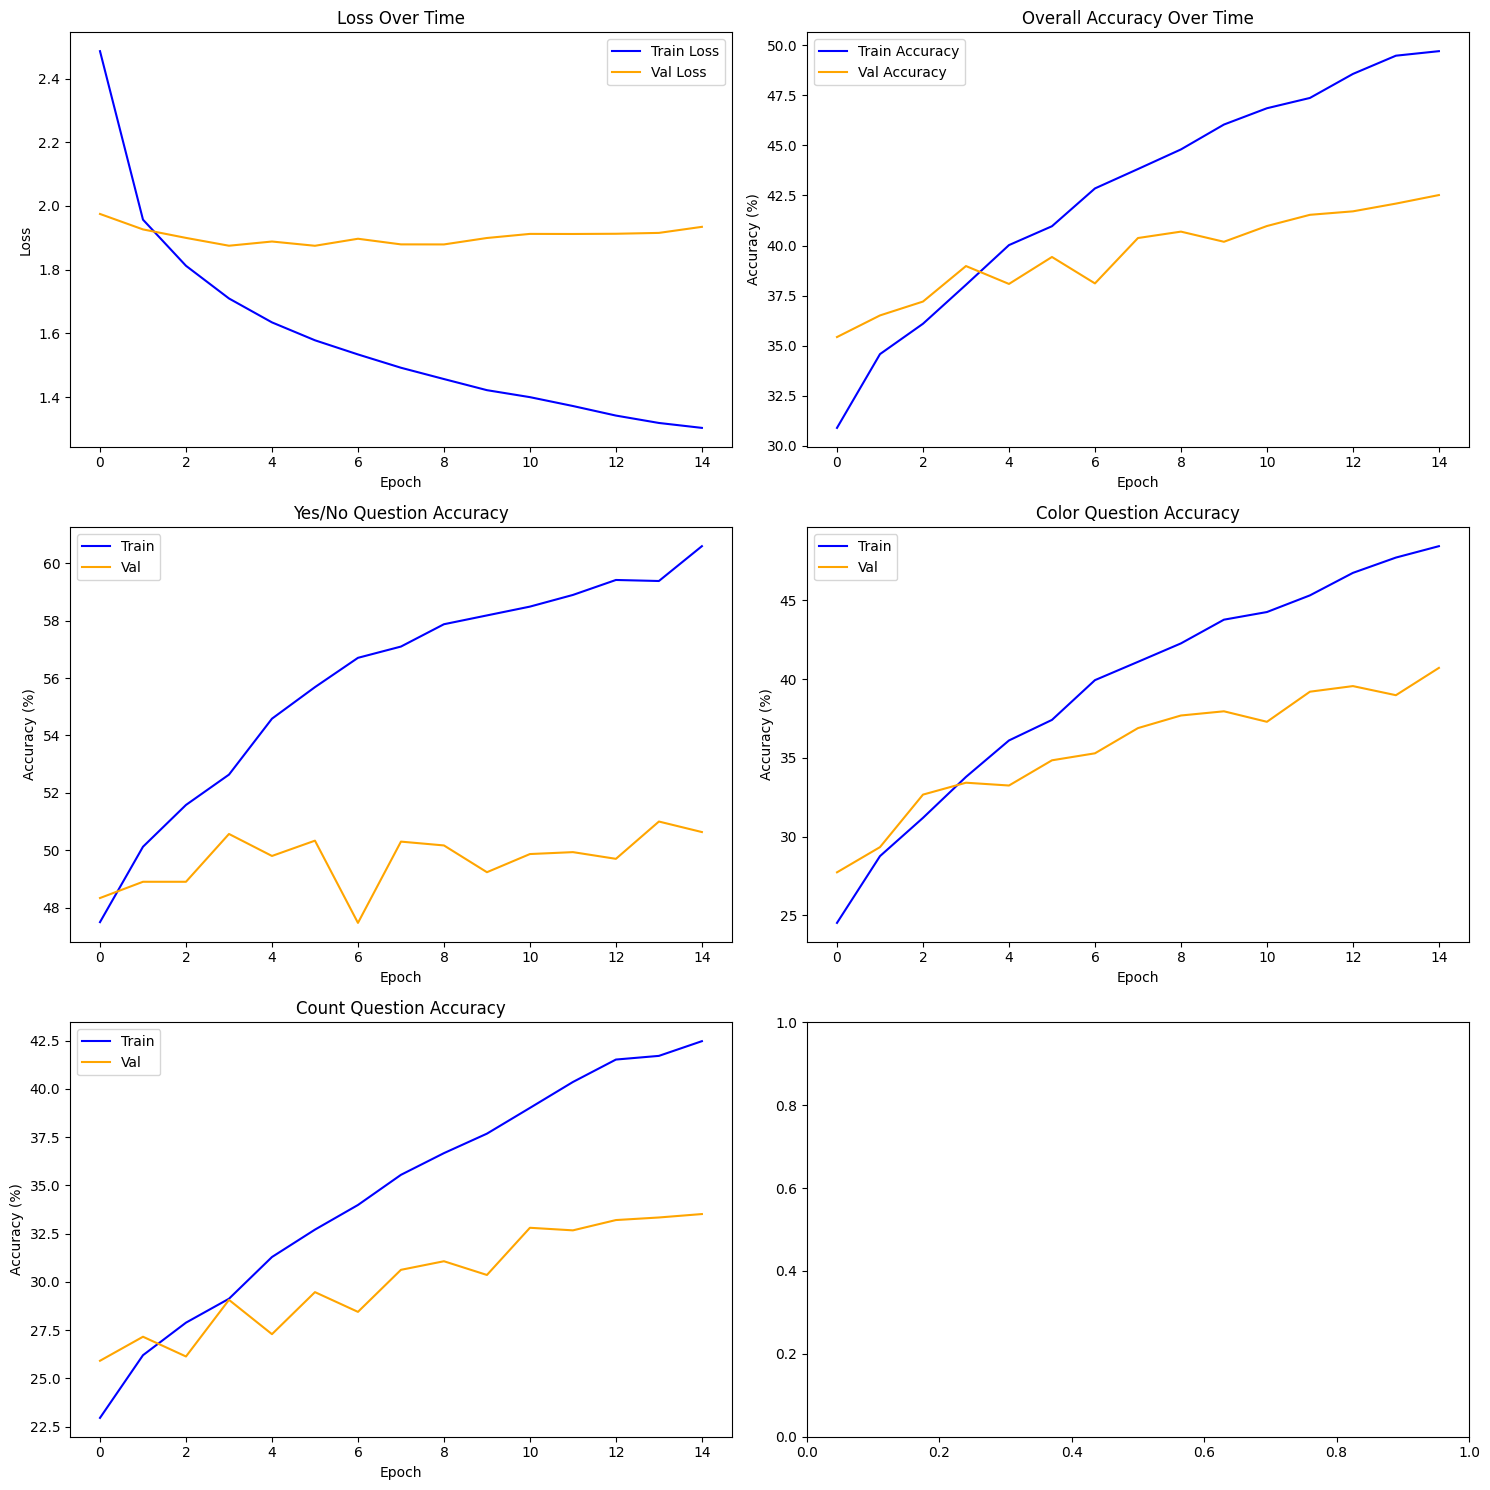

In [8]:
# Train with attention fusion
history_attention = train_and_evaluate(config, datasets, fusion_type='attention')

### VISUALIZATION


In [ ]:
def visualize_dual_attention_maps(model, dataloader, num_samples=5):
    model.eval()
    device = next(model.parameters()).device

    # Collecting samples
    samples = []
    for batch in dataloader:
        if len(samples) >= num_samples:
            break
        samples.extend([{
            'clip_img': batch['clip_image'][i],
            'vit_image': batch['vit_image'][i],
            'question': {
                'input_ids': batch['question']['input_ids'][i],
                'attention_mask': batch['question']['attention_mask'][i]
            },
            'answer_text': batch['answer_text'][i],
            'question_text': batch['question_text'][i],
            'answer': batch['answer'][i]
        } for i in range(min(num_samples - len(samples), len(batch['clip_image'])))])


    # Visualization setup
    fig = plt.figure(figsize=(20, 6 * num_samples))
    for idx, sample in enumerate(samples):
        with torch.no_grad():
            outputs = model(
                clip_image=sample['clip_img'].unsqueeze(0).to(device),
                question={
                    'input_ids': sample['question']['input_ids'].unsqueeze(0).to(device),
                    'attention_mask': sample['question']['attention_mask'].unsqueeze(0).to(device)
                },
                output_attentions=True
            )

            # Prediction
            logits = outputs['logits'] if isinstance(outputs, dict) else outputs
            pred = logits.argmax(dim=1)
            pred_text = dataloader.dataset.ans_proc.idx2ans[pred.item()]

            # CLIP attention process
            clip_attention = outputs['vision_model_output'].attentions[-1]
            clip_attention = clip_attention.mean(dim=1).squeeze(0)[0, 1:]
            patch_size = int(np.sqrt(clip_attention.shape[0]))
            clip_attention = clip_attention.reshape(patch_size, patch_size)
            
            # ViT attention process
            vit_attention = outputs['vit_attentions'][-1]
            vit_attention = vit_attention.mean(dim=1).squeeze(0)[0, 1:]
            vit_patch_size = int(np.sqrt(vit_attention.shape[0]))
            vit_attention = vit_attention.reshape(vit_patch_size, vit_patch_size)
            


            clip_attention = F.interpolate(
                clip_attention.unsqueeze(0).unsqueeze(0),
                size=(224, 224),
                mode='bilinear',
                align_corners=False
            ).squeeze().cpu().numpy()

            vit_attention = F.interpolate(
                vit_attention.unsqueeze(0).unsqueeze(0),
                size=(224, 224),
                mode='bilinear',
                align_corners=False
            ).squeeze().cpu().numpy()

            # Normalization
            clip_attention = (clip_attention - clip_attention.min()) / (clip_attention.max() - clip_attention.min())
            vit_attention = (vit_attention - vit_attention.min()) / (vit_attention.max() - vit_attention.min())
            combined_attention = (clip_attention + vit_attention) / 2



        # Plotting
        # Image and attention maps
        ax = fig.add_subplot(num_samples, 5, idx * 5 + 1)
        img = transforms.ToPILImage()(sample['clip_img'])
        ax.imshow(img)
        ax.axis('off')
        ax.set_title('Original Image')

        ax = fig.add_subplot(num_samples, 5, idx * 5 + 2)
        im1 = ax.imshow(clip_attention, cmap='hot')
        ax.axis('off')
        ax.set_title('CLIP Attention')
        plt.colorbar(im1, ax=ax)

        ax = fig.add_subplot(num_samples, 5, idx * 5 + 3)
        im2 = ax.imshow(vit_attention, cmap='hot')
        ax.axis('off')
        ax.set_title('ViT Attention')
        plt.colorbar(im2, ax=ax)

        ax = fig.add_subplot(num_samples, 5, idx * 5 + 4)
        im3 = ax.imshow(combined_attention, cmap='hot')
        ax.axis('off')
        ax.set_title('Combined Attention')
        plt.colorbar(im3, ax=ax)

        ax = fig.add_subplot(num_samples, 5, idx * 5 + 5)
        ax.imshow(img)
        ax.imshow(combined_attention, alpha=0.5, cmap='hot')
        ax.axis('off')
        title = f"Q: {sample['question_text']}\nPredicted: {pred_text}\nGround Truth: {sample['answer_text']}"
        ax.set_title(title, fontsize=8, wrap=True)

    plt.tight_layout()
    plt.show()

In [ ]:
# BLEU AND METEOR SCORES
def calculate_nlp_metrics(model, dataloader, answer_processor):
    
    nltk.download('wordnet', quiet=True)
    model.eval()
    device = next(model.parameters()).device
    smoother = SmoothingFunction()
    
    bleu_scores = {'bleu1': [], 'bleu2': [], 'bleu3': [], 'cumulative': []}
    meteor_scores = []
    example_preds = []
    
    weight_configs = {
        'bleu1': (1, 0, 0),
        'bleu2': (0.5, 0.5, 0),
        'bleu3': (0.33, 0.33, 0.33)
    }
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Calculating NLP metrics"):
            outputs = model(
                clip_image=batch['clip_image'].to(device),
                question={
                    'input_ids': batch['question']['input_ids'].to(device),
                    'attention_mask': batch['question']['attention_mask'].to(device)
                }
            )
            
            logits = outputs['logits'] if isinstance(outputs, dict) else outputs
            preds = logits.argmax(dim=1)
            
            pred_texts = [answer_processor.idx2ans[idx.item()].lower() for idx in preds]
            true_texts = [ans.lower() for ans in batch['answer_text']]
            
            for pred, true in zip(pred_texts, true_texts):
                if len(example_preds) < 5:
                    example_preds.append((pred, true))
                
                pred_tokens = pred.split()
                true_tokens = [true.split()]
                
                if not pred_tokens or not true_tokens[0]:
                    continue
                    
                # BLEU scores
                for name, weights in weight_configs.items():
                    score = sentence_bleu(true_tokens, pred_tokens, weights=weights, 
                                       smoothing_function=smoother.method1)
                    bleu_scores[name].append(score)
                
                # METEOR
                meteor = meteor_score([true_tokens[0]], pred_tokens)
                if not np.isnan(meteor):
                    meteor_scores.append(meteor)
    

    metrics = {
        'bleu_scores': {k: np.mean(v) for k, v in bleu_scores.items()},
        'meteor': np.mean(meteor_scores),
        'examples': example_preds
    }
    
    return metrics

In [ ]:
def analyze_model_results(config, datasets, fusion_type):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    checkpoint_path = os.path.join(config.model_dir, f'best_dual_encoder_{fusion_type}_final_vqa.pth')
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    model = DualEncoderVQA(
        num_answers=len(datasets['test'].ans_proc.ans2idx),
        config=config,
        fusion_type=fusion_type,
        dropout=0.2
    ).to(device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Evaluation dataloader
    eval_loader = DataLoader(
        datasets['test'],
        batch_size=32,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
        collate_fn=collate_fn
    )
    
    # Visualization of dataloader
    viz_loader = DataLoader(
        datasets['test'],
        batch_size=8,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
        collate_fn=collate_fn
    )
    
    results = {}
    
    # Attention visualizations
    print("Generating attention visualizations...")
    visualize_dual_attention_maps(model, viz_loader, num_samples=5)
    
    # NLP metrics
    print("\nCalculating NLP metrics...")
    nlp_metrics = calculate_nlp_metrics(model, eval_loader, datasets['test'].ans_proc)
    results['nlp_metrics'] = nlp_metrics
    
    # Analysis of question types
    print("\nAnalyzing performance by question type...")
    type_metrics = {'yes/no': [], 'color': [], 'count': []}
    
    with torch.no_grad():
        for batch in tqdm(eval_loader):
            outputs = model(
                clip_image=batch['clip_image'].to(device),
                question={
                    'input_ids': batch['question']['input_ids'].to(device),
                    'attention_mask': batch['question']['attention_mask'].to(device)
                }
            )
            
            logits = outputs['logits'] if isinstance(outputs, dict) else outputs
            preds = logits.argmax(dim=1)
            
            for i, (pred, true) in enumerate(zip(preds, batch['answer'])):
                q_type = batch['question_type'][i]
                if q_type in type_metrics:
                    type_metrics[q_type].append((pred == true).item())


    # Calculation of accuracies
    results['question_type_accuracy'] = {
        q_type: np.mean(scores) * 100 
        for q_type, scores in type_metrics.items()
    }
    
    # Results
    print("\nResults:")
    print(f"BLEU-1: {nlp_metrics['bleu_scores']['bleu1']:.4f}")
    print(f"METEOR: {nlp_metrics['meteor']:.4f}")
    print("\nAccuracy by question type:")
    for q_type, acc in results['question_type_accuracy'].items():
        print(f"{q_type}: {acc:.2f}%")
        
    return results

C:\Users\csury\AppData\Local\Temp\ipykernel_24716\1704116175.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device


Trainable layers:
  vit.encoder.layer.10.attention.attention.query.weight
  vit.encoder.layer.10.attention.attention.query.bias
  vit.encoder.layer.10.attention.attention.key.weight
  vit.encoder.layer.10.attention.attention.key.bias
  vit.encoder.layer.10.attention.attention.value.weight
  vit.encoder.layer.10.attention.attention.value.bias
  vit.encoder.layer.10.attention.output.dense.weight
  vit.encoder.layer.10.attention.output.dense.bias
  vit.encoder.layer.10.intermediate.dense.weight
  vit.encoder.layer.10.intermediate.dense.bias
  vit.encoder.layer.10.output.dense.weight
  vit.encoder.layer.10.output.dense.bias
  vit.encoder.layer.10.layernorm_before.weight
  vit.encoder.layer.10.layernorm_before.bias
  vit.encoder.layer.10.layernorm_after.weight
  vit.encoder.layer.10.layernorm_after.bias
  vit.encoder.layer.11.attention.attention.query.weight
  vit.encoder.layer.11.attention.attention.query.bias
  vit.encoder.layer.11.attention.attention.key.weight
  vit.encoder.layer.11.at

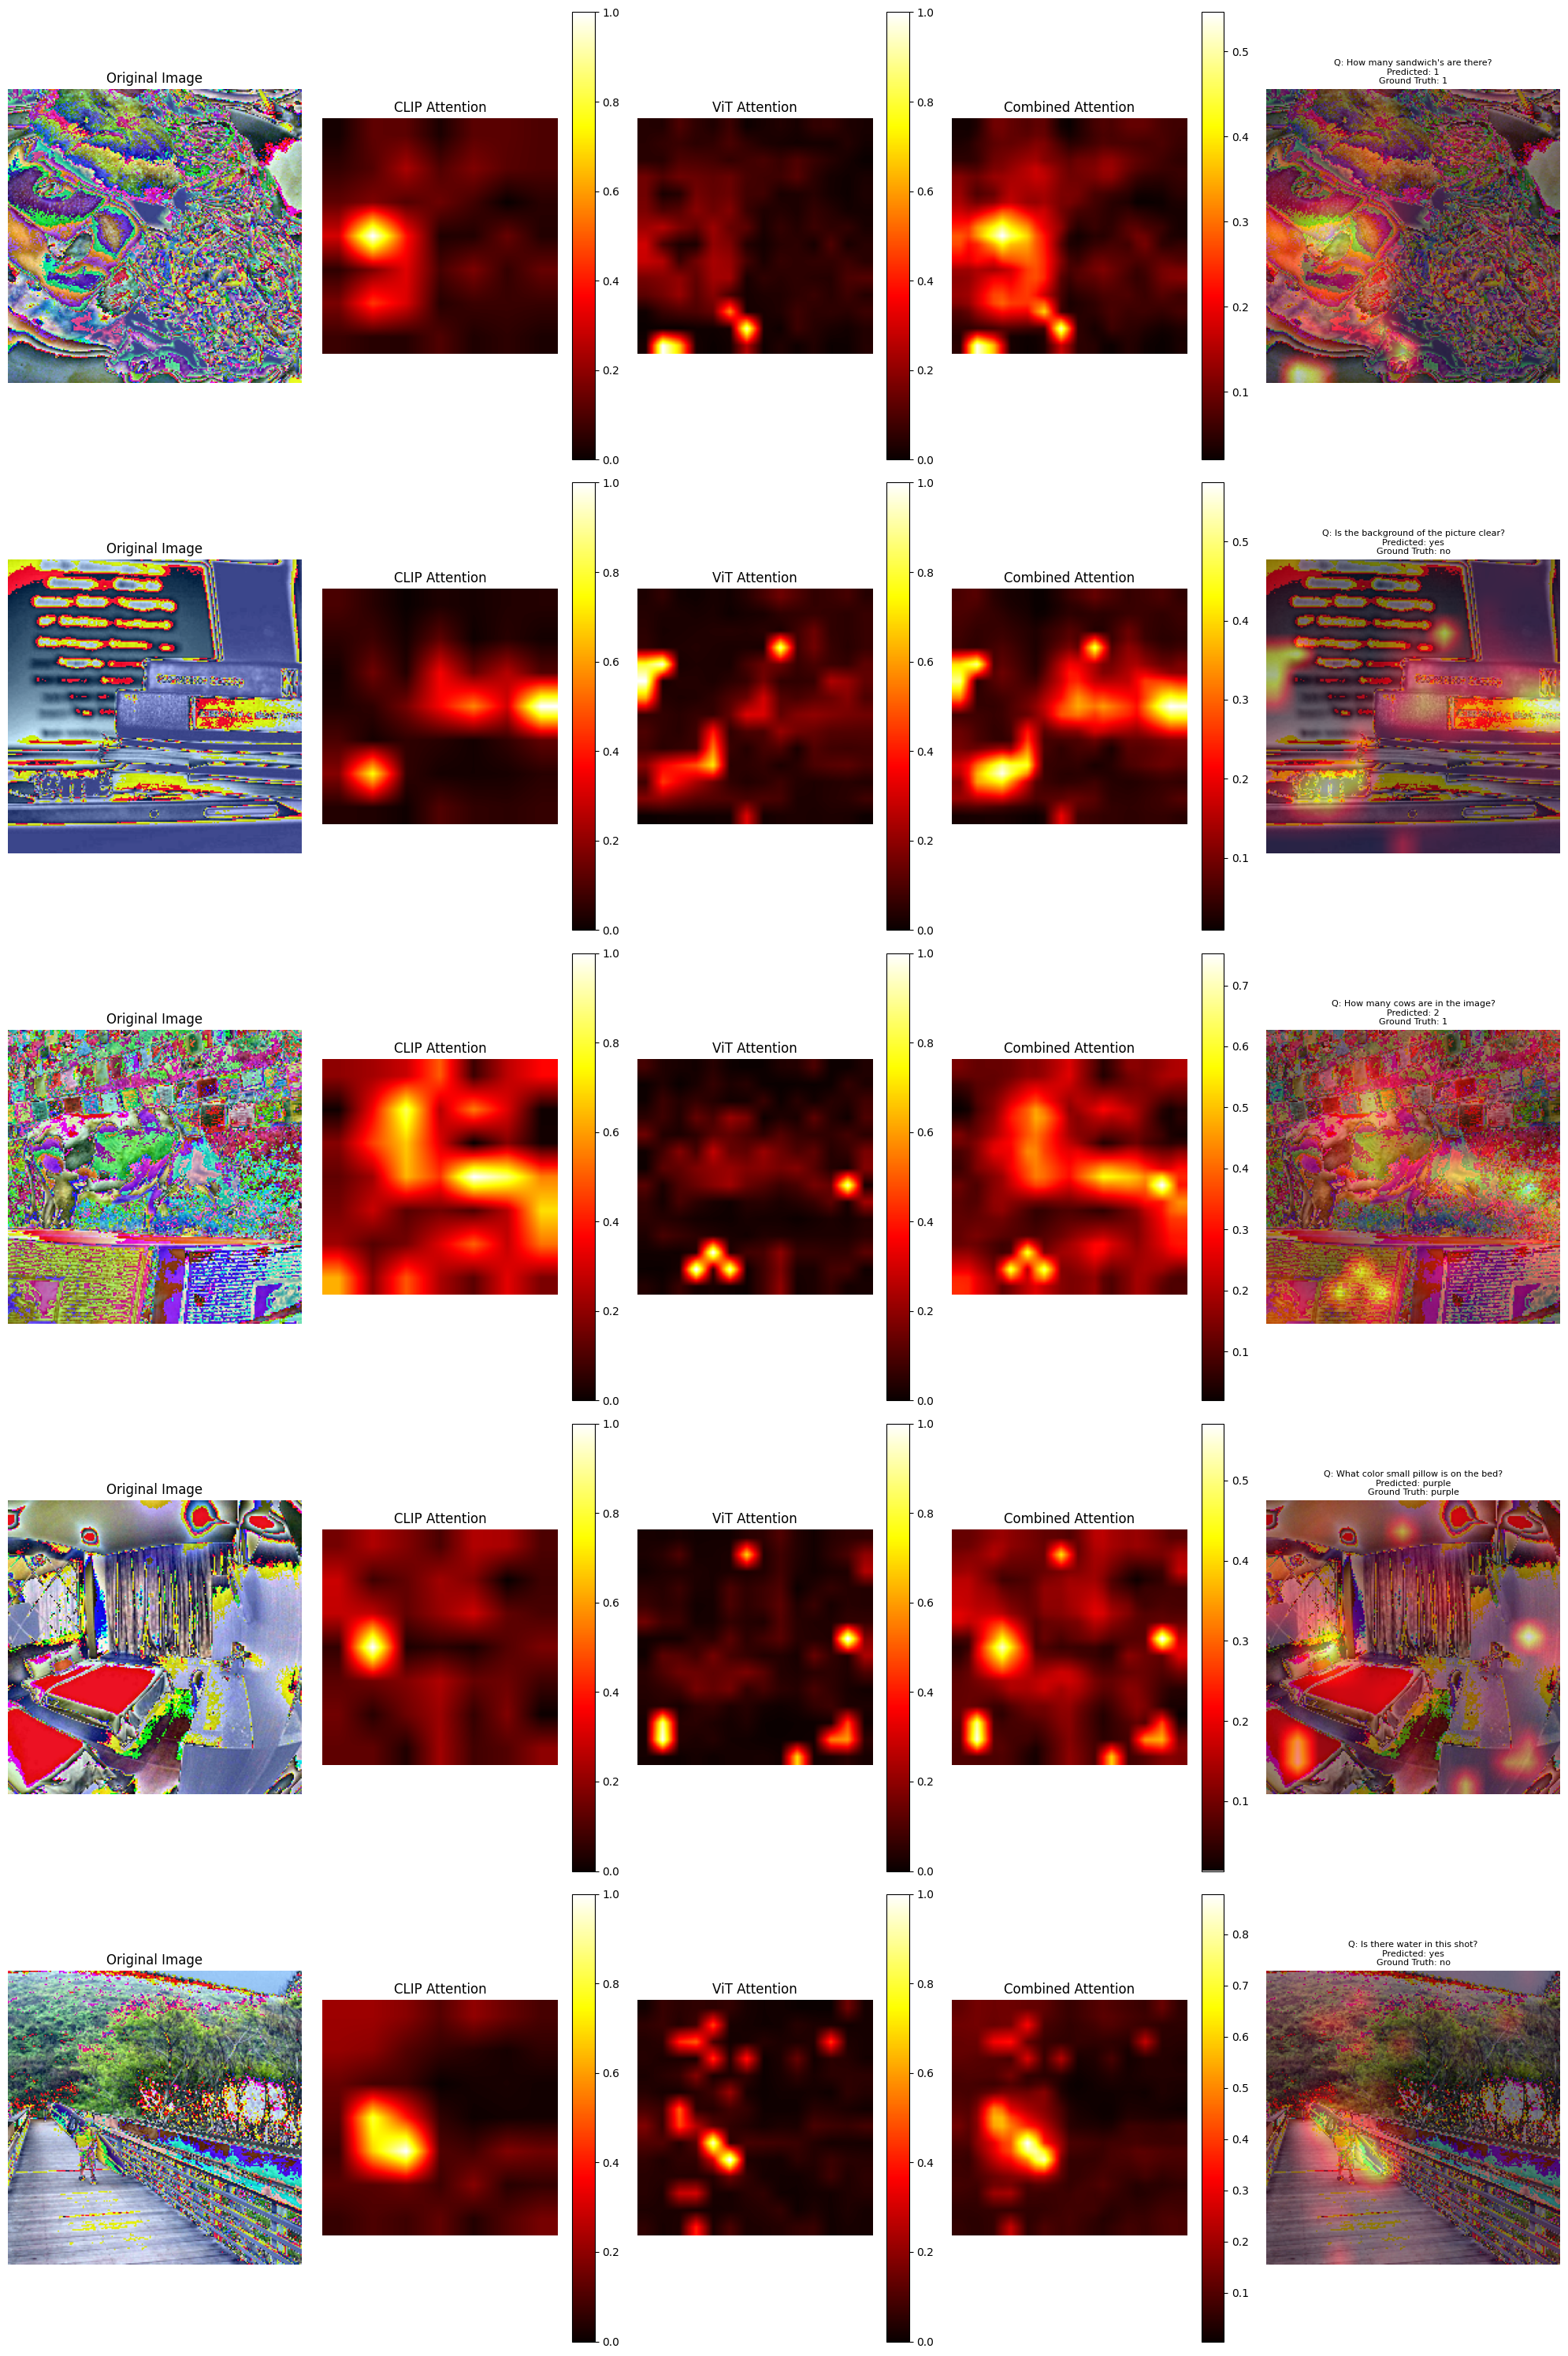


Calculating NLP metrics...


Calculating NLP metrics: 100%|██████████| 235/235 [02:19<00:00,  1.69it/s]



Analyzing performance by question type...


100%|██████████| 235/235 [02:32<00:00,  1.54it/s]


Results:
BLEU-1: 0.4326
METEOR: 0.2214

Accuracy by question type:
yes/no: 50.77%
color: 42.31%
count: 33.29%


{'nlp_metrics': {'bleu_scores': {'bleu1': 0.43258092544820836,
   'bleu2': 0.14185872258397939,
   'bleu3': 0.10024537362986792,
   'cumulative': nan},
  'meteor': 0.22139057626365746,
  'examples': [('white', 'white'),
   ('1', '2'),
   ('usa', 'usa'),
   ('no', 'yes'),
   ('yes', 'yes')]},
 'question_type_accuracy': {'yes/no': 50.76666666666667,
  'color': 42.31111111111111,
  'count': 33.28888888888889}}

In [29]:
analyze_model_results(config, datasets, fusion_type = 'attention')

## TESTING DEMO

In [ ]:
def get_test_image_info(test_dataset, num_samples=5, random=False):
    # Deciding whhich indices to visualize
    if random:
        indices = np.random.choice(len(test_dataset), num_samples)
    else:
        indices = range(num_samples)
    
    ncols = 3
    nrows = (num_samples + ncols - 1) // ncols
    
    plt.figure(figsize=(15, 5 * nrows))
    
    for i, idx in enumerate(indices):
        sample = test_dataset[idx]
        
        # Displaying
        plt.subplot(nrows, ncols, i + 1)
        img = sample['clip_image'].cpu()
        img = img * 0.5 + 0.5  
        img = img.permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Sample {i}')  
    
    plt.tight_layout()
    plt.show()


In [ ]:
def test_vqa_model_manual(model, test_dataset, sample_idx, question_text):
    model.eval()
    device = next(model.parameters()).device

    try:
        sample = test_dataset[sample_idx]
        clip_image = sample['clip_image'].unsqueeze(0).to(device)

        # Processing question
        question_tokens = test_dataset.question_processor(question_text)
        question_input = {
            'input_ids': question_tokens['input_ids'].to(device),
            'attention_mask': question_tokens['attention_mask'].to(device)
        }

        # Model prediction
        with torch.no_grad():
            output = model(clip_image, question_input)
            logits = output['logits'] if isinstance(output, dict) else output
            pred_idx = logits.argmax(dim=1).item()
            pred_answer = test_dataset.answer_processor.idx2answer.get(pred_idx, "Unknown")
            confidence = torch.softmax(logits, dim=1).max().item()

        # Results
        plt.figure(figsize=(12, 6))

        # Display
        # Image
        plt.subplot(1, 2, 1)
        img = sample['clip_image'].cpu()
        img = img * 0.5 + 0.5  
        img = img.permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.axis('off')
        plt.title('Input Image')

        # Q&A
        plt.subplot(1, 2, 2)
        plt.axis('off')
        plt.text(0.1, 0.5, f"My Question: {question_text}", wrap=True)
        plt.text(0.1, 0.4, f"Model's Answer: {pred_answer}", wrap=True, color='blue')
        plt.text(0.1, 0.3, f"Confidence: {confidence:.2%}", wrap=True)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error during inference in manual testing: {e}")
        raise




def test_vqa_model_with_details(model, test_dataset, sample_idx, question_text):
    model.eval()
    device = next(model.parameters()).device

    try:
        sample = test_dataset[sample_idx]
        clip_image = sample['clip_image'].unsqueeze(0).to(device)

        question_tokens = test_dataset.question_processor(question_text)
        question_input = {
            'input_ids': question_tokens['input_ids'].to(device),
            'attention_mask': question_tokens['attention_mask'].to(device)
        }

        with torch.no_grad():
            outputs = model(clip_image, question_input, output_attentions=True)
            logits = outputs['logits']

            # Extraction of attention maps
            clip_attentions = outputs['vision_model_output'].attentions[-1]
            vit_attentions = outputs['vit_attentions'][-1]

            # CLIP attention process
            clip_attention = clip_attentions.mean(dim=1).squeeze(0)
            clip_attention = clip_attention[0, 1:]
            patch_size = int(np.sqrt(clip_attention.shape[0]))
            clip_attention = clip_attention.reshape(patch_size, patch_size)

            # ViT attention process
            vit_attention = vit_attentions.mean(dim=1).squeeze(0)
            vit_attention = vit_attention[0, 1:]
            vit_patch_size = int(np.sqrt(vit_attention.shape[0]))
            vit_attention = vit_attention.reshape(vit_patch_size, vit_patch_size)

            clip_attention = F.interpolate(
                clip_attention.unsqueeze(0).unsqueeze(0),
                size=(224, 224),
                mode='bilinear',
                align_corners=False
            ).squeeze().cpu().numpy()

            vit_attention = F.interpolate(
                vit_attention.unsqueeze(0).unsqueeze(0),
                size=(224, 224),
                mode='bilinear',
                align_corners=False
            ).squeeze().cpu().numpy()

            clip_attention = (clip_attention - clip_attention.min()) / (clip_attention.max() - clip_attention.min())
            vit_attention = (vit_attention - vit_attention.min()) / (vit_attention.max() - vit_attention.min())
            combined_attention = (clip_attention + vit_attention) / 2

            pred_idx = logits.argmax(dim=1).item()
            pred_answer = test_dataset.answer_processor.idx2answer.get(pred_idx, "Unknown")
            confidence = torch.softmax(logits, dim=1).max().item()

        plt.figure(figsize=(20, 10))


        # Results
        # Original image
        plt.subplot(2, 3, 1)
        img = sample['clip_image'].cpu()
        img = transforms.ToPILImage()(img)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Original Image')

        # Q&A
        plt.subplot(2, 3, 2)
        plt.axis('off')
        plt.text(0, 0.7, f"My Question: {question_text}", wrap=True, fontsize=12)
        plt.text(0, 0.4, f"Model's Answer: {pred_answer}", wrap=True, color='blue', fontsize=12)
        plt.text(0, 0.1, f"Confidence: {confidence:.2%}", wrap=True, fontsize=12)

        # CLIP attention
        plt.subplot(2, 3, 4)
        im1 = plt.imshow(clip_attention, cmap='hot')
        plt.axis('off')
        plt.title('CLIP Attention')
        plt.colorbar(im1)

        # ViT attention
        plt.subplot(2, 3, 5)
        im2 = plt.imshow(vit_attention, cmap='hot')
        plt.axis('off')
        plt.title('ViT Attention')
        plt.colorbar(im2)

        # Combined attention
        plt.subplot(2, 3, 6)
        im3 = plt.imshow(combined_attention, cmap='hot')
        plt.axis('off')
        plt.title('Combined Attention')
        plt.colorbar(im3)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error during inference in detailed testing: {e}")
        raise




def evaluate_model_manual_input(config, test_dataset, sample_idx, question, model_type='dual_encoder_attention_final'):
    checkpoint_path = os.path.join(config.models_dir, f'best_{model_type}_vqa.pth')

    if not os.path.exists(checkpoint_path):
        print(f"Model checkpoint not found at {checkpoint_path}")
        return

    try:
        num_answers = len(test_dataset.answer_processor.ans2idx)
        fusion_type = 'attention'
        model = DualEncoderVQA(
            num_answers=num_answers,
            config=config,
            fusion_type=fusion_type,
            dropout=0.15
        )

        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(model.device)
        model.eval()

        print(f"Model loaded successfully from {checkpoint_path}")
        print(f"Validation accuracy: {checkpoint['val_metrics']['accuracy']:.2f}%")

        test_vqa_model_manual(model, test_dataset, sample_idx, question)
        test_vqa_model_with_details(model, test_dataset, sample_idx, question)

    except Exception as e:
        print(f"Error during model evaluation: {e}")
        raise


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39613128..1.5729485].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39613128..1.5729485].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38883203..1.5729485].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39613128..1.5302883].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.36693442..1.5729485].


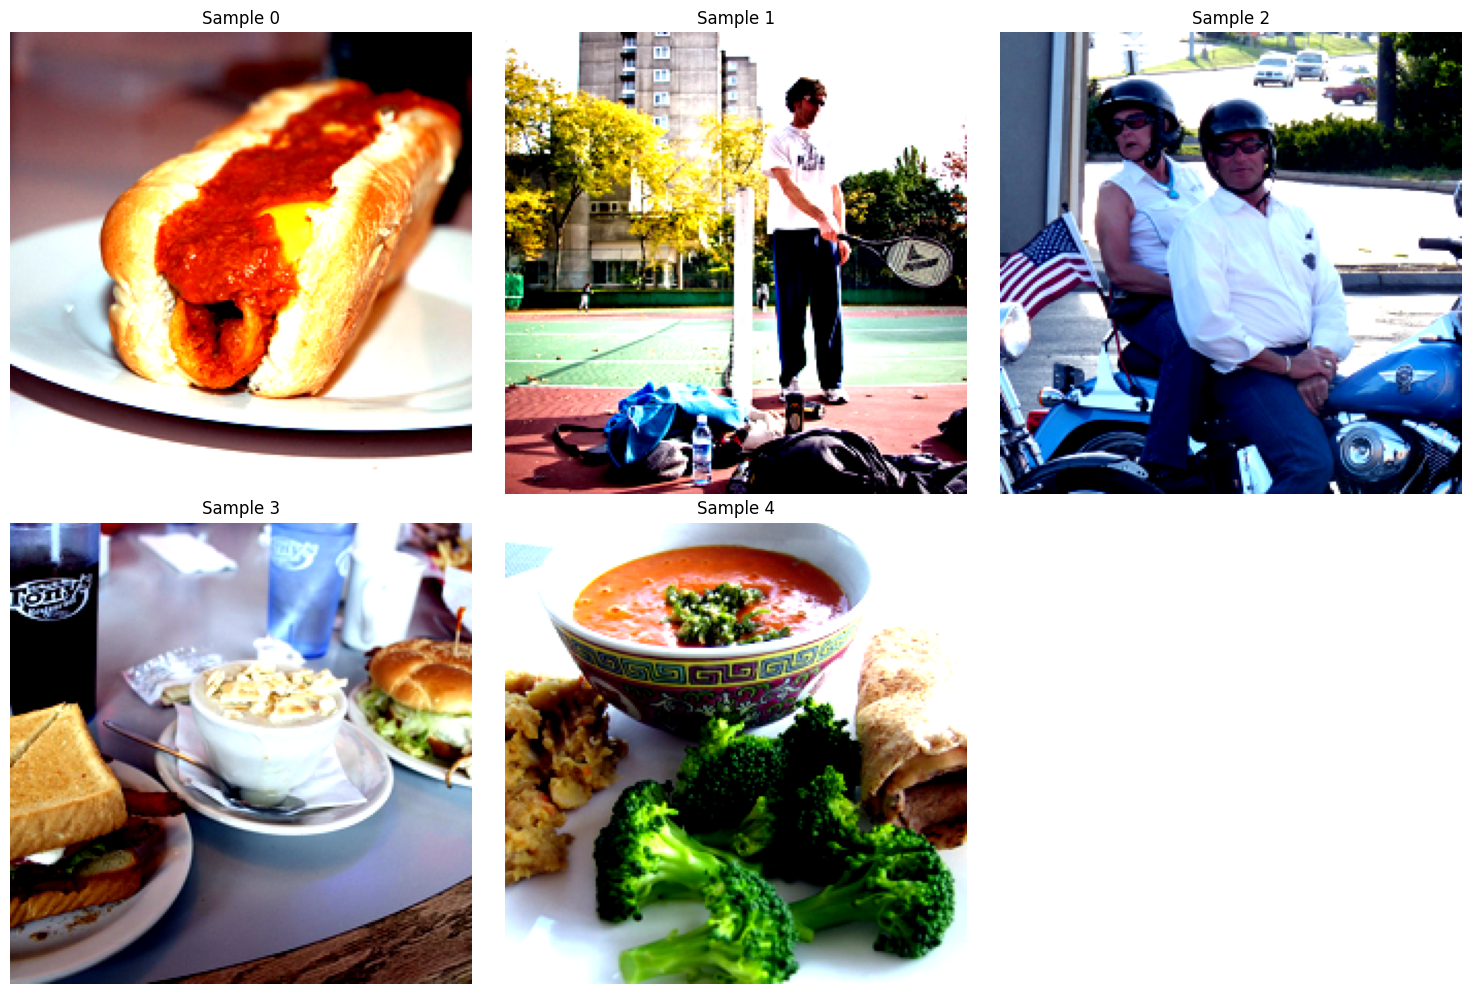

In [14]:

get_test_image_info(datasets['test'], num_samples=5)


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Trainable layers:
  vit.encoder.layer.10.attention.attention.query.weight
  vit.encoder.layer.10.attention.attention.query.bias
  vit.encoder.layer.10.attention.attention.key.weight
  vit.encoder.layer.10.attention.attention.key.bias
  vit.encoder.layer.10.attention.attention.value.weight
  vit.encoder.layer.10.attention.attention.value.bias
  vit.encoder.layer.10.attention.output.dense.weight
  vit.encoder.layer.10.attention.output.dense.bias
  vit.encoder.layer.10.intermediate.dense.weight
  vit.encoder.layer.10.intermediate.dense.bias
  vit.encoder.layer.10.output.dense.weight
  vit.encoder.layer.10.output.dense.bias
  vit.encoder.layer.10.layernorm_before.weight
  vit.encoder.layer.10.layernorm_before.bias
  vit.encoder.layer.10.layernorm_after.weight
  vit.encoder.layer.10.layernorm_after.bias
  vit.encoder.layer.11.attention.attention.query.weight
  vit.encoder.layer.11.attention.attention.query.bias
  vit.encoder.layer.11.attention.attention.key.weight
  vit.encoder.layer.11.at

C:\Users\csury\AppData\Local\Temp\ipykernel_14012\927989458.py:181: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
Clipping input dat

Model loaded successfully from C:\Users\csury\Documents\DL\PROJECT\models\best_dual_encoder_attention_5_vqa.pth
Validation accuracy: 43.04%


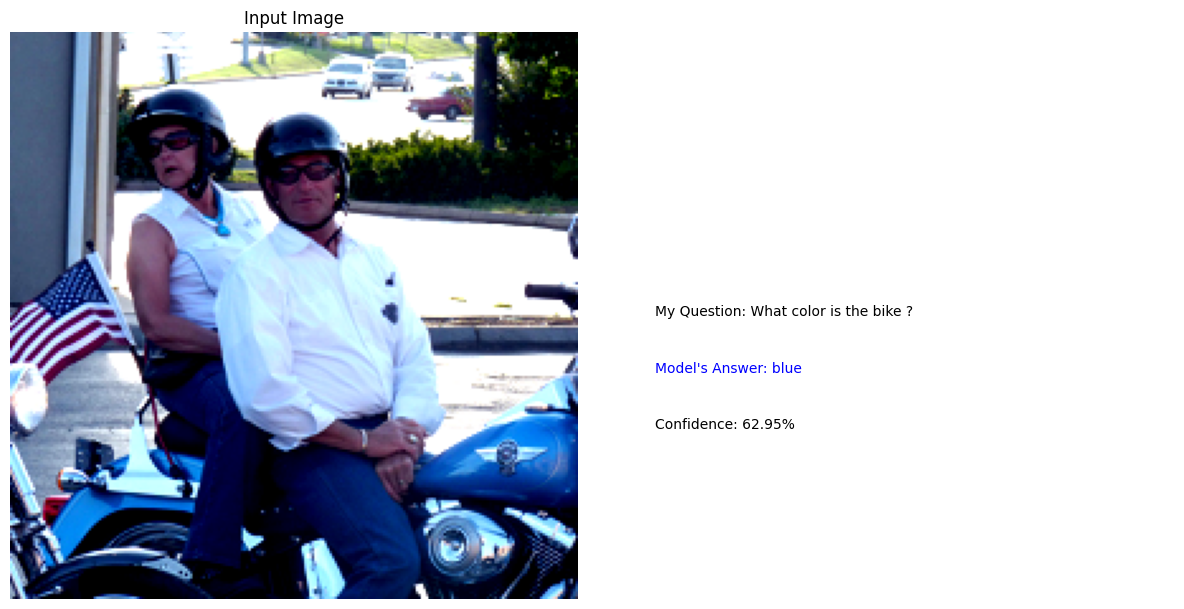

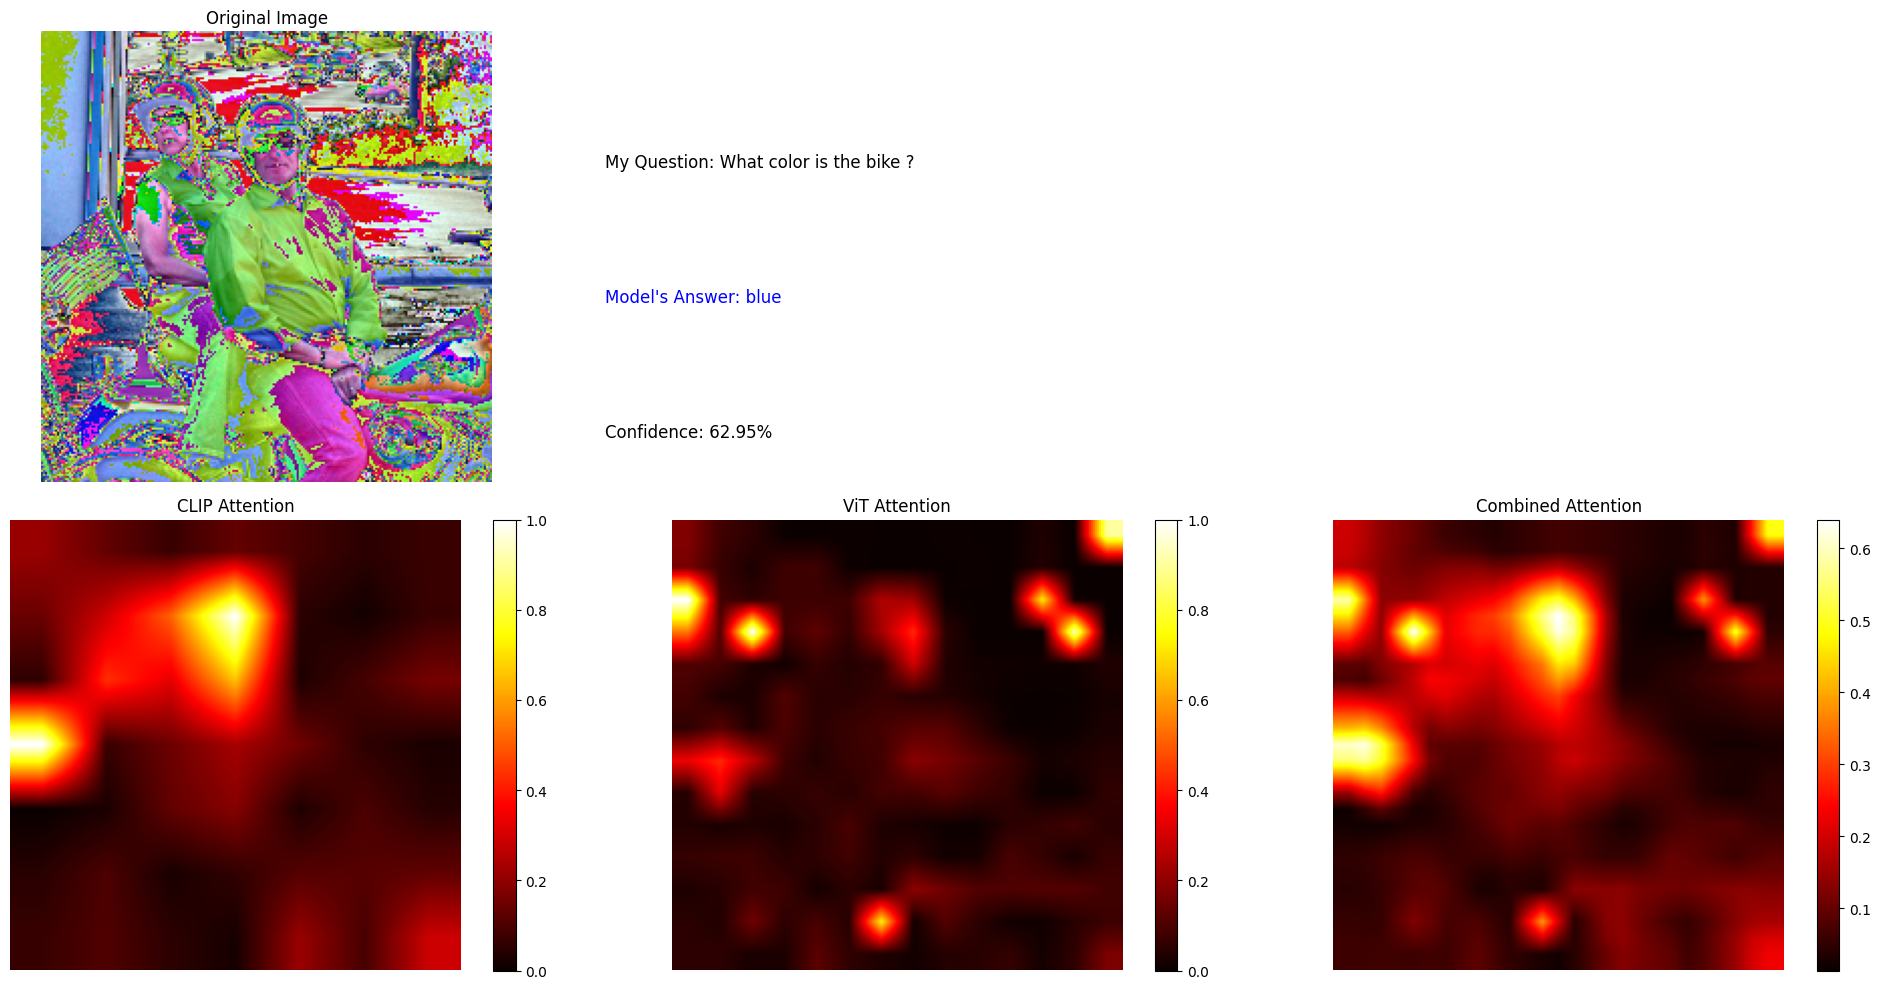

In [ ]:
sample_idx = 2  
test_question = "What color is the bike ?"  
model_type = 'dual_encoder_attention_final'  


evaluate_model_manual_input(config, datasets['test'], 
                          sample_idx=sample_idx,
                          question=test_question,
                          model_type=model_type)